<a href="https://colab.research.google.com/github/ssingh1187/DS-Unit-2-Sprint-3-Advanced-Regression/blob/master/DS_Unit_2_Sprint_Challenge_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Science Unit 2 Sprint Challenge 3

## Logistic Regression and Beyond

In this sprint challenge you will fit a logistic regression modeling the probability of an adult having an income above 50K. The dataset is available at UCI:

https://archive.ics.uci.edu/ml/datasets/adult

Your goal is to:

1. Load, validate, and clean/prepare the data.
2. Fit a logistic regression model
3. Answer questions based on the results (as well as a few extra questions about the other modules)

Don't let the perfect be the enemy of the good! Manage your time, and make sure to get to all parts. If you get stuck wrestling with the data, simplify it (if necessary, drop features or rows) so you're able to move on. If you have time at the end, you can go back and try to fix/improve.

### Hints

It has a variety of features - some are continuous, but many are categorical. You may find [pandas.get_dummies](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) (a method to one-hot encode) helpful!

The features have dramatically different ranges. You may find [sklearn.preprocessing.minmax_scale](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.minmax_scale.html#sklearn.preprocessing.minmax_scale) helpful!

## Part 1 - Load, validate, and prepare data

The data is available at: https://archive.ics.uci.edu/ml/datasets/adult

Load it, name the columns, and make sure that you've loaded the data successfully. Note that missing values for categorical variables can essentially be considered another category ("unknown"), and may not need to be dropped.

You should also prepare the data for logistic regression - one-hot encode categorical features as appropriate.

In [0]:
# age: continuous.
# workclass: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
# fnlwgt: continuous.
# education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
# education-num: continuous.
# marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
# occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
# relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
# race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
# sex: Female, Male.
# capital-gain: continuous.
# capital-loss: continuous.
# hours-per-week: continuous.
# native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

In [1]:
# To remember: Missing values cannot be dropped

import pandas as pd

data_df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data', header=None,
                     names=['age','workclass','fnlwgt','education','education_num', 'marital_status',
                            'occupation','relationship','race','sex','capital_gain','capital_loss',
                            'hours_per_week','native_country', 'income'])
print(data_df.shape)
data_df.head()

(32561, 15)


,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [2]:
# to find null values

data_df.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income            0
dtype: int64

In [0]:
# To find value counts of all columns: df.apply(pd.value_counts)

# print(data_df.apply(pd.value_counts))

# Does not work

In [3]:
import numpy as np
data_df = data_df.replace('?', np.nan)
data_df.isna().sum()

age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income            0
dtype: int64

In [4]:
# Finding '?' using trail and error method

#data_df.age
data_df.workclass

0                State-gov
1         Self-emp-not-inc
2                  Private
3                  Private
4                  Private
5                  Private
6                  Private
7         Self-emp-not-inc
8                  Private
9                  Private
10                 Private
11               State-gov
12                 Private
13                 Private
14                 Private
15                 Private
16        Self-emp-not-inc
17                 Private
18                 Private
19        Self-emp-not-inc
20                 Private
21                 Private
22             Federal-gov
23                 Private
24                 Private
25               Local-gov
26                 Private
27                       ?
28                 Private
29                 Private
               ...        
32531                    ?
32532              Private
32533              Private
32534              Private
32535              Private
32536              Private
3

In [5]:
# there are '?' values for sure. Maybe there are some white spaces before or after '?'..

data_df.loc[data_df['workclass']==' ?']

# white space before '?' is confirmed

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
27,54,?,180211,Some-college,10,Married-civ-spouse,?,Husband,Asian-Pac-Islander,Male,0,0,60,South,>50K
61,32,?,293936,7th-8th,4,Married-spouse-absent,?,Not-in-family,White,Male,0,0,40,?,<=50K
69,25,?,200681,Some-college,10,Never-married,?,Own-child,White,Male,0,0,40,United-States,<=50K
77,67,?,212759,10th,6,Married-civ-spouse,?,Husband,White,Male,0,0,2,United-States,<=50K
106,17,?,304873,10th,6,Never-married,?,Own-child,White,Female,34095,0,32,United-States,<=50K
128,35,?,129305,HS-grad,9,Married-civ-spouse,?,Husband,White,Male,0,0,40,United-States,<=50K
149,43,?,174662,Some-college,10,Divorced,?,Not-in-family,White,Female,0,0,40,United-States,<=50K
154,52,?,252903,HS-grad,9,Divorced,?,Not-in-family,White,Male,0,0,45,United-States,>50K
160,68,?,38317,1st-4th,2,Divorced,?,Not-in-family,White,Female,0,0,20,United-States,<=50K
187,53,?,135105,Bachelors,13,Divorced,?,Not-in-family,White,Female,0,0,50,United-States,<=50K


In [6]:
data_df = data_df.replace(' ?', np.nan)#, inplace=True)

data_df.isna().sum()

# Haaa. Finally worked!

age                  0
workclass         1836
fnlwgt               0
education            0
education_num        0
marital_status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital_gain         0
capital_loss         0
hours_per_week       0
native_country     583
income               0
dtype: int64

In [7]:
# Since the NaN values are in categorical columns, I am going to use bfill or ffill
# For reference: https://towardsdatascience.com/the-tale-of-missing-values-in-python-c96beb0e8a9d

data_df = data_df.fillna(method='ffill')
data_df.isna().sum()


age               0
workclass         0
fnlwgt            0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
income            0
dtype: int64

In [8]:
data_df.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [9]:
# Since, income column is a categorical columns and also our target;

data_df.income.replace({' <=50K': 0, ' >50K': 1}, inplace=True)
data_df.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [10]:
data_df.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education_num      int64
marital_status    object
occupation        object
relationship      object
race              object
sex               object
capital_gain       int64
capital_loss       int64
hours_per_week     int64
native_country    object
income             int64
dtype: object

####One-hot encode

In [0]:
# # For reference: https://towardsdatascience.com/the-dummys-guide-to-creating-dummy-variables-f21faddb1d40

# # selecting numeric columns
# numeric_cols = data_df.select_dtypes('number')
# categorical_cols = data_df.select_dtypes('object')

# # One-hot encode
# df2 = pd.get_dummies(data_df)

# print(df2.shape)
# df2.head()


(32561, 106)


,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,income,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Never-worked,...,native_country_ Portugal,native_country_ Puerto-Rico,native_country_ Scotland,native_country_ South,native_country_ Taiwan,native_country_ Thailand,native_country_ Trinadad&Tobago,native_country_ United-States,native_country_ Vietnam,native_country_ Yugoslavia
0,39,77516,13,2174,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,0,0,13,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,215646,9,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,53,234721,7,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,28,338409,13,0,0,40,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
from sklearn.preprocessing import LabelEncoder

df_encoded = data_df.select_dtypes(exclude=['number']) \
.apply(LabelEncoder().fit_transform) \
.join(data_df.select_dtypes(include=['number']))

print(df_encoded.shape)
df_encoded.head()

(32561, 15)


,workclass,education,marital_status,occupation,relationship,race,sex,native_country,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,income
0,6,9,4,0,1,4,1,38,39,77516,13,2174,0,40,0
1,5,9,2,3,0,4,1,38,50,83311,13,0,0,13,0
2,3,11,0,5,1,4,1,38,38,215646,9,0,0,40,0
3,3,1,2,5,0,2,1,38,53,234721,7,0,0,40,0
4,3,9,2,9,5,2,0,4,28,338409,13,0,0,40,0


In [0]:
# Shape is preserved

## Part 2 - Fit and present a Logistic Regression

Your data should now be in a state to fit a logistic regression. Use scikit-learn, define your `X` (independent variable) and `y`, and fit a model.

Then, present results - display coefficients in as interpretible a way as you can (hint - scaling the numeric features will help, as it will at least make coefficients more comparable to each other). If you find it helpful for interpretation, you can also generate predictions for cases (like our 5 year old rich kid on the Titanic) or make visualizations - but the goal is your exploration to be able to answer the question, not any particular plot (i.e. don't worry about polishing it).

It is *optional* to use `train_test_split` or validate your model more generally - that is not the core focus for this week. So, it is suggested you focus on fitting a model first, and if you have time at the end you can do further validation.

In [21]:
# Defining dependent and independent variables

import sklearn
from sklearn.preprocessing import MinMaxScaler

X = df_encoded.drop('income', axis='columns')
y = df_encoded['income']

X_scaled = sklearn.preprocessing.minmax_scale(X, feature_range=(0, 1), axis=0, copy=True)
print(X_scaled.shape)
print(y.shape)

# shapes are preserved

(32561, 14)
(32561,)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64 were all converted to float64.
  


In [23]:
X_scaled

array([[0.85714286, 0.6       , 0.66666667, ..., 0.02174022, 0.        ,
        0.39795918],
       [0.71428571, 0.6       , 0.33333333, ..., 0.        , 0.        ,
        0.12244898],
       [0.42857143, 0.73333333, 0.        , ..., 0.        , 0.        ,
        0.39795918],
       ...,
       [0.42857143, 0.73333333, 1.        , ..., 0.        , 0.        ,
        0.39795918],
       [0.42857143, 0.73333333, 0.66666667, ..., 0.        , 0.        ,
        0.19387755],
       [0.57142857, 0.73333333, 0.33333333, ..., 0.1502415 , 0.        ,
        0.39795918]])

In [32]:
# Logistic Regression

from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='lbfgs')
df_reg = model.fit(X_scaled, y)
df_reg.score(X_scaled, y)

0.8229476981665182

In [30]:
# Lets try train test split 

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, y, test_size =.2, random_state=42)

model = LogisticRegression(random_state=42, solver='lbfgs', multi_class='multinomial')
model.fit(X_train, Y_train)
model.score(X_test, Y_test)

0.8235836020267158

In [0]:
# the model is a good fit.

In [45]:
# What's the math?
print(df_encoded.drop('income',axis=1).columns)
print(df_reg.coef_[0])
      

Index(['workclass', 'education', 'marital_status', 'occupation',
       'relationship', 'race', 'sex', 'native_country', 'age', 'fnlwgt',
       'education_num', 'capital_gain', 'capital_loss', 'hours_per_week'],
      dtype='object')
[-6.04085928e-01  2.23826197e-01 -1.36848086e+00  1.64704003e-03
 -5.92509561e-01  4.66404881e-01  8.92487988e-01  6.59910837e-02
  2.51948915e+00  6.82123535e-01  4.91298248e+00  1.87222379e+01
  2.73802763e+00  2.91678072e+00]


In [51]:
# Array of coefficients from the features

coefs_dict = {'Name':df_encoded.drop('income', axis=1).columns.tolist(),
              'Coefficient':df_reg.coef_[0]}

coefs = pd.DataFrame(coefs_dict)
coefs

,Coefficient,Name
0,-0.604086,workclass
1,0.223826,education
2,-1.368481,marital_status
3,0.001647,occupation
4,-0.592510,relationship
5,0.466405,race
6,0.892488,sex
7,0.065991,native_country
8,2.519489,age
9,0.682124,fnlwgt


In [57]:
# prediction of salary
y_pred = df_reg.predict(X_scaled)
y_pred.shape

(32561,)

In [0]:
from sklearn.metrics import confusion_matrix

# sklearn.metrics.confusion_matrix(y_true, y_pred, labels=None, sample_weight=None)

cfm = confusion_matrix(y, y_pred)

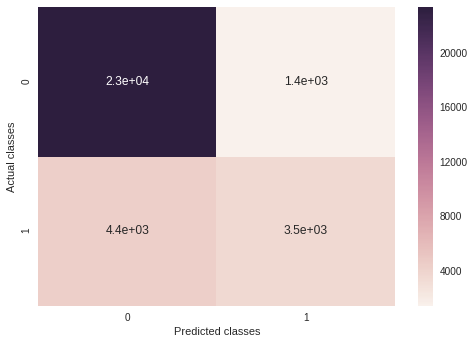

In [62]:
# Confusion matrix plot

import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cfm, annot=True)
plt.xlabel('Predicted classes')
plt.ylabel('Actual classes');

From the above plot, we can say that 2.3e+04 times the model correctly predicted the class 0 when the actual class was 0.

## Part 3 - Analysis, Interpretation, and Questions

### Based on your above model, answer the following questions

1. What are 3 features positively correlated with income above 50k?
2. What are 3 features negatively correlated with income above 50k?
3. Overall, how well does the model explain the data and what insights do you derive from it?

*These answers count* - that is, make sure to spend some time on them, connecting to your analysis above. There is no single right answer, but as long as you support your reasoning with evidence you are on the right track.

Note - scikit-learn logistic regression does *not* automatically perform a hypothesis test on coefficients. That is OK - if you scale the data they are more comparable in weight.

### Match the following situation descriptions with the model most appropriate to addressing them

In addition to logistic regression, a number of other approaches were covered this week. Pair them with the situations they are most appropriate for, and briefly explain why.

Situations:
1. You are given data on academic performance of primary school students, and asked to fit a model to help predict "at-risk" students who are likely to receive the bottom tier of grades.
2. You are studying tech companies and their patterns in releasing new products, and would like to be able to model and predict when a new product is likely to be launched.
3. You are working on modeling expected plant size and yield with a laboratory that is able to capture fantastically detailed physical data about plants, but only of a few dozen plants at a time.

Approaches:
1. Ridge Regression
2. Quantile Regression
3. Survival Analysis

**Answers**
1. What are 3 features positively correlated with income above 50k?


In [68]:
coefs.sort_values('Coefficient', ascending=False)

,Coefficient,Name
11,18.722238,capital_gain
10,4.912982,education_num
13,2.916781,hours_per_week
12,2.738028,capital_loss
8,2.519489,age
6,0.892488,sex
9,0.682124,fnlwgt
5,0.466405,race
1,0.223826,education
7,0.065991,native_country


We can say that capital gain, education and hours per week positively correlate with income.

2. What are 3 features negatively correlated with income above 50k?

In [67]:
coefs.sort_values('Coefficient', ascending=True)

,Coefficient,Name
2,-1.368481,marital_status
0,-0.604086,workclass
4,-0.592510,relationship
3,0.001647,occupation
7,0.065991,native_country
1,0.223826,education
5,0.466405,race
9,0.682124,fnlwgt
6,0.892488,sex
8,2.519489,age


From the above table, marital status, workclass and relationship negatively correlate with income.

3. Overall, how well does the model explain the data and what insights do you derive from it?


From the score of 0.8229476981665182 we can say that the model is a good fit. 

It is surprising to see that factors like race and age positively coorelate with income, even though the coefficients are small.



Situations:
1. You are given data on academic performance of primary school students, and asked to fit a model to help predict "at-risk" students who are likely to receive the bottom tier of grades.
>Quantile Analysis: It helps in analysis of data in different quantiles. In this case, the bottom tier of grades will be the lowest quantile.

2. You are studying tech companies and their patterns in releasing new products, and would like to be able to model and predict when a new product is likely to be launched.
> Survival Analysis:  It is useful in determining the **time-to-event** analysis. It would help in determing the `waiting period` to launch the new product.

3. You are working on modeling expected plant size and yield with a laboratory that is able to capture fantastically detailed physical data about plants, but only of a few dozen plants at a time.
>Ridge Regression: Ridge regression minimizes the sum of square error of the residuals AND the squared slope of the fit model, times the alpha parameter. It works with accuracy with small amount of data.


